#  Initialisation et importation des données

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import h5py 
import numpy as np

In [0]:
f = h5py.File('drive/My Drive/PLP project/Dreem/train.h5','r')
list(f)

['accelerometer_x',
 'accelerometer_y',
 'accelerometer_z',
 'eeg_1',
 'eeg_2',
 'eeg_3',
 'eeg_4',
 'eeg_5',
 'eeg_6',
 'eeg_7',
 'pulse_oximeter_infrared']

## Filtrage

Pour le prétraitement des données, nous avons choisi de prendre 4 versions filtrées de chaque signal 

In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
  
BDelta=butter_bandpass(0.01,4,50,order=3)
BTheta=butter_bandpass(4,6.5,50,order=3)
BAlpha=butter_bandpass(6.5,11,50,order=3)
BBeta=butter_bandpass(11,20,50,order=3)
BGamma=butter_bandpass(20,24,50,order=3)


## Extraction de  features

Dans cette partie, l'extraction se fait avec des fonction numpy se basant sur le parallélisme, elle se fait rapidement comparant avec le "slow extraction" juste au dessous qui fait l'extraction avec une boucle sur toutes les lignes

### Fast extraction (parallélisme)

In [0]:
def extract_features(f,eeg,acc):
  df = pd.DataFrame()
  for label in eeg:
    # variance of each signal
    d1 = lfilter(BDelta[0], BDelta[1],f[label][:],axis=1)
    t1=  lfilter(BTheta[0], BTheta[1],f[label][:],axis=1)
    a1 = lfilter(BAlpha[0], BAlpha[1],f[label][:],axis=1)
    g1 = lfilter(BGamma[0], BGamma[1],f[label][:],axis=1)
    # d
    column_var = pd.Series(np.var(f[label][:], axis = 1))
    df['VarianceD'+label] = column_var
    # energy of each signal
    column_ener =pd.Series(np.sum(np.sqrt(d1*d1),axis = 1))
    df["EnergyD"+label]=column_ener
    #Entropy
    column_entr =pd.Series(np.sum(d1*d1*np.log(abs(d1)),axis = 1))
    df["EntropyD"+label]=column_entr
    
    column_var = pd.Series(np.var(t1, axis = 1))
    df['VarianceT'+label] = column_var
    # energy of each signal
    column_ener =pd.Series(np.sum(np.sqrt(t1*t1),axis = 1))
    df["EnergyT"+label]=column_ener
    #Entropy
    column_entr =pd.Series(np.sum(t1*t1*np.log(abs(t1)),axis = 1))
    df["EntropyT"+label]=column_entr
    column_var = pd.Series(np.var(a1, axis = 1))
    df['VarianceA'+label] = column_var
    # energy of each signal
    column_ener =pd.Series(np.sum(np.sqrt(a1*a1),axis = 1))
    df["EnergyA"+label]=column_ener
    #Entropy
    column_entr =pd.Series(np.sum(g1*g1*np.log(abs(g1)),axis = 1))
    df["EntropyA"+label]=column_entr
    df['VarianceG'+label] = column_var
    # energy of each signal
    column_ener =pd.Series(np.sum(np.sqrt(g1*g1),axis = 1))
    df["EnergyG"+label]=column_ener
    #Entropy
    column_entr =pd.Series(np.sum(g1*g1*np.log(abs(g1)),axis = 1))
    df["EntropyG"+label]=column_entr
  for label in acc:
    # variance of each signal
    column_var = pd.Series(np.var(f[label][:], axis = 1))
    df[label+"_"+"var"] = column_var
    # variance of each signal
    column_mean = pd.Series(np.mean(f[label][:], axis = 1))
    df[label+"_"+"mean"] = column_mean
    
  return(df)
l=['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5','eeg_6','eeg_7']
acc=['accelerometer_x',
 'accelerometer_y','accelerometer_z']
import time
tmps1=time.clock()
df=extract_features(f,l,acc)
tmps2=time.clock()
print(tmps2-tmps1)

3.7876309999999993


### Slow extraction

In [0]:
def Entropy(x):
  return(np.sum(x*x*np.log(abs(x))).astype(type('float', (float,), {})))
def Energy(x):
  return(np.sum(np.sqrt(x*x)).astype(type('float', (float,), {})))
def Ecart_type(x):
  return(np.var(x).astype(type('float', (float,), {})))

In [0]:
import time
EntropyD1=[]
EntropyT1=[]
EntropyA1=[]
EntropyG1=[]
EnergyD1=[]
EnergyT1=[]
EnergyA1=[]
EnergyG1=[]
ECD1=[]
ECT1=[]
ECA1=[]
ECG1=[]
Mx=[]
My=[]
Mz=[]
Sx=[]
Sy=[]
Sz=[]
dfu=pd.DataFrame(np.zeros((200,18)), columns=["EntropyD1", "EntropyT1","EntropyA1","EntropyG1","EnergyD1","EnergyT1","EnergyA1","EnergyG1","ECD1","ECT1","ECA1","ECG1","Mx","My","Mz","Sx","Sy","Sz"])
tmps1=time.clock()

for i in range(100):
  if i%10==0:
    print(i)
  v1=f["eeg_1"][:][i]
  vx=f["accelerometer_x"][:][i]
  vy=f["accelerometer_y"][:][i]
  vz=f["accelerometer_z"][:][i]
  d1 = lfilter(BDelta[0], BDelta[1],v1)
  t1=  lfilter(BTheta[0], BTheta[1],v1)
  a1 = lfilter(BAlpha[0], BAlpha[1],v1)
  g1 = lfilter(BGamma[0], BGamma[1],v1)
  
  EntropyD1.append(Entropy(d1))
  EntropyT1.append(Entropy(t1))
  EntropyA1.append(Entropy(a1))
  EntropyG1.append(Entropy(g1))
  EnergyD1.append(Energy(d1))
  EnergyT1.append(Energy(t1))
  EnergyA1.append(Energy(a1))
  EnergyG1.append(Energy(g1))
  ECD1.append(Ecart_type(d1))
  ECT1.append(Ecart_type(t1))
  ECA1.append(Ecart_type(a1))
  ECG1.append(Ecart_type(g1))
  Mx.append(np.mean(vx))
  My.append(np.mean(vy))
  Mz.append(np.mean(vz))
  Sx.append(Ecart_type(vx))
  Sy.append(Ecart_type(vy))
  Sz.append(Ecart_type(vz))
tmps2=time.clock()
print(tmps2-tmps1)

0
10
20
30
40
50
60
70
80
90
533.8514660000001


In [0]:
df.head()

,VarianceDeeg_1,EnergyDeeg_1,EntropyDeeg_1,VarianceTeeg_1,EnergyTeeg_1,EntropyTeeg_1,VarianceAeeg_1,EnergyAeeg_1,EntropyAeeg_1,VarianceGeeg_1,...,EntropyAeeg_7,VarianceGeeg_7,EnergyGeeg_7,EntropyGeeg_7,accelerometer_x_var,accelerometer_x_mean,accelerometer_y_var,accelerometer_y_mean,accelerometer_z_var,accelerometer_z_mean
0,327.913418,18186.310000,1.608893e+06,7.965741,3162.483238,1.831332e+04,6.649141,2857.110683,3680.011188,6.649141,...,41200.781411,46.508059,3318.484794,41200.781411,1.621020e-06,-0.000025,4.314815e-06,0.000122,3.293953e-06,-0.000053
1,634.051694,27976.473886,3.214697e+06,21.404189,4917.403356,6.934785e+04,10.770712,3508.849069,1436.798840,10.770712,...,2331.562705,28.048525,1761.036826,2331.562705,1.057023e-07,-0.000005,1.425968e-07,-0.000014,5.060436e-07,0.000001
2,237110.757336,174067.128941,2.778797e+09,1251.247284,10187.244955,1.071720e+07,169.636602,4600.565238,1826.260440,169.636602,...,2479.713219,17.301207,1789.749083,2479.713219,1.670079e-06,0.000034,1.077994e-06,0.000029,6.769185e-07,0.000042
3,38.693771,6057.099030,1.014804e+05,2.303627,1784.041496,2.891541e+03,2.218116,1770.207043,203.685148,2.218116,...,3055.283146,10.127654,1887.772473,3055.283146,2.508012e-07,0.000019,1.430208e-07,0.000009,3.258193e-07,-0.000027
4,59.230668,8145.364406,1.637927e+05,3.728306,2321.140006,5.688684e+03,4.868073,2623.657942,141.207608,4.868073,...,108401.406766,12399.198136,5033.912627,108401.406766,2.567212e-07,0.000008,1.990289e-07,0.000037,3.972578e-07,0.000003


In [0]:
file='drive/My Drive/PLP project/Dreem/train_y.csv'
labels=pd.read_csv(file)
df["labels"]=labels["sleep_stage"]

In [0]:
df.head()

,VarianceDeeg_1,EnergyDeeg_1,EntropyDeeg_1,VarianceTeeg_1,EnergyTeeg_1,EntropyTeeg_1,VarianceAeeg_1,EnergyAeeg_1,EntropyAeeg_1,VarianceGeeg_1,...,VarianceGeeg_7,EnergyGeeg_7,EntropyGeeg_7,accelerometer_x_var,accelerometer_x_mean,accelerometer_y_var,accelerometer_y_mean,accelerometer_z_var,accelerometer_z_mean,labels
0,327.913418,18186.310000,1.608893e+06,7.965741,3162.483238,1.831332e+04,6.649141,2857.110683,3680.011188,6.649141,...,46.508059,3318.484794,41200.781411,1.621020e-06,-0.000025,4.314815e-06,0.000122,3.293953e-06,-0.000053,3
1,634.051694,27976.473886,3.214697e+06,21.404189,4917.403356,6.934785e+04,10.770712,3508.849069,1436.798840,10.770712,...,28.048525,1761.036826,2331.562705,1.057023e-07,-0.000005,1.425968e-07,-0.000014,5.060436e-07,0.000001,3
2,237110.757336,174067.128941,2.778797e+09,1251.247284,10187.244955,1.071720e+07,169.636602,4600.565238,1826.260440,169.636602,...,17.301207,1789.749083,2479.713219,1.670079e-06,0.000034,1.077994e-06,0.000029,6.769185e-07,0.000042,3
3,38.693771,6057.099030,1.014804e+05,2.303627,1784.041496,2.891541e+03,2.218116,1770.207043,203.685148,2.218116,...,10.127654,1887.772473,3055.283146,2.508012e-07,0.000019,1.430208e-07,0.000009,3.258193e-07,-0.000027,2
4,59.230668,8145.364406,1.637927e+05,3.728306,2321.140006,5.688684e+03,4.868073,2623.657942,141.207608,4.868073,...,12399.198136,5033.912627,108401.406766,2.567212e-07,0.000008,1.990289e-07,0.000037,3.972578e-07,0.000003,2


Ci-dessous, nous comparons le temps d'apprentissage et la précision en termes de validation du modèle avec Scikit learn en fonction de la taille de l'échantillon. Pour ce faire, nous choisissons aléatoirement 20% des échantillons. Cette partie de la donnée constituera la donnée de la validation. Par la suite nous varions à chaque itération la taille de la deuxième partie pour effectuer le training.

In [0]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.model_selection import train_test_split
import time
temps=[]
test_err=[]
taille=[]
y=df.iloc[:,-1]
X=df.iloc[:,:-1]
N=len(y)
c=0.1
X1,X_test, y1, y_test = train_test_split(X, y, test_size=0.2)
y=df.iloc[:,-1]
X=df.iloc[:,:-1]
for i in range(9):
  X_train, _, y_train, _ = train_test_split(X1, y1, test_size=c)
  clf=RandomForestClassifier(n_estimators=100)
  taille.append(len(y_train))
  tmps1=time.clock()
  clf.fit(X_train,y_train)
  tmps2=time.clock()
  temps.append(tmps2-tmps1)
  y_pred_test=clf.predict(X_test)
  test_err.append(accuracy_score(y_test, y_pred_test))
  c=c+0.1
  print(i)

0
1
2
3
4
5
6
7
8


In [0]:
print(taille)

[27567, 24504, 21441, 18378, 15315, 12252, 9189, 6126, 3063]


In [0]:
print(test_err)

[0.7320449203447376, 0.7222512405327762, 0.7246017236876469, 0.7200313397753982, 0.714416296683207, 0.6991381561765474, 0.6864716636197441, 0.6726299294855054, 0.6493862627317838]


In [0]:
print(temps)

[32.19396800000004, 27.947626000000014, 23.943944999999985, 19.720287999999982, 15.627562999999952, 11.863446000000067, 8.585178000000042, 5.3029829999999265, 2.3182520000000295]


Ci-dessous je présentons les résultats

Text(0.5, 0, "La taille de l'échantillon")

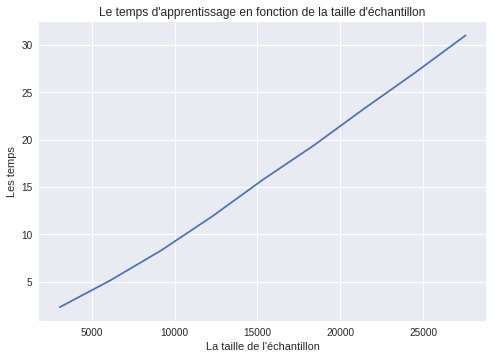

In [0]:

import matplotlib.pyplot as plt
plt.plot(taille,temps)
plt.title("Le temps d'apprentissage en fonction de la taille d'échantillon")
plt.ylabel('Les temps')
plt.xlabel("La taille de l'échantillon")


Text(0.5, 0, "La taille de l'échantillon")

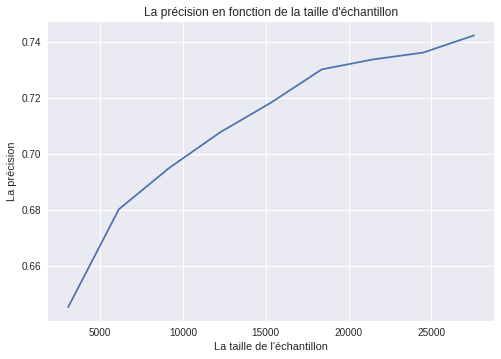

In [0]:
import matplotlib.pyplot as plt
plt.plot(taille,test_err)
plt.title("La précision en fonction de la taille d'échantillon")
plt.ylabel('La précision')
plt.xlabel("La taille de l'échantillon")

In [0]:
df.to_csv("drive/My Drive/PLP project/data_dreem.csv")